# ANALYSIS NASA TLX

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.stats.anova import AnovaRM
from scipy.stats import zscore
from scipy.stats import shapiro
from scipy.stats import probplot
from tabulate import tabulate


conn = sqlite3.connect(
    r"C:\Users\max-j\OneDrive\Desktop\Bachelorarbeit_Auswertung\Datenbanken\Auswertung\app_database_2")

queryDataCombinedAvg = """SELECT
    id,
    UserID,
    ScenarioCase,
    mental_demand,
    physical_demand,
    temporal_demand,
    perfromance,
    effort,
    frustration,
    (
      mental_demand +
      physical_demand +
      temporal_demand +
      perfromance +
      effort +
      frustration
    ) / 6.0 AS Score         -- Durchschnitt aller 6 Dimensionen
FROM nasa_tlx;"""

observed_group = 'UserID'
tested_variable = 'Score'

DataCombinedAvg = pd.read_sql_query(queryDataCombinedAvg, conn)
DataCombinedAvgAggregated = DataCombinedAvg.groupby([observed_group, 'ScenarioCase'])["Score"].mean().reset_index()


DataCombinedAvgAggregated[f'{tested_variable}_z_within'] = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].transform(zscore)


for data in DataCombinedAvgAggregated[f'{tested_variable}_z_within']:
    if data >= 2.5 or data <= -2.5:
        print(f"Significant outlier {data}")

# Gibt es einen Effekt auf die durchschnittliche Performance?

In [2]:
#Average PerformanceGeneral for each scenario
DataUserScenario = DataCombinedAvgAggregated.groupby('ScenarioCase')[[tested_variable]].mean().reset_index()
print(DataUserScenario)

    ScenarioCase     Score
0         FOLDAR  6.097222
1     FOLDAROPEN  6.111111
2  STATEOFTHEART  6.069444


# Check for normality

Shapiro-Wilk Normality Test Results per ScenarioCase:
Scenario: FOLDAR          | Shapiro-Wilk Statistic: 0.953148244206 | p-value: 0.683364071659
Scenario: FOLDAROPEN      | Shapiro-Wilk Statistic: 0.886742662564 | p-value: 0.106986492617
Scenario: STATEOFTHEART   | Shapiro-Wilk Statistic: 0.954993767821 | p-value: 0.710699678108


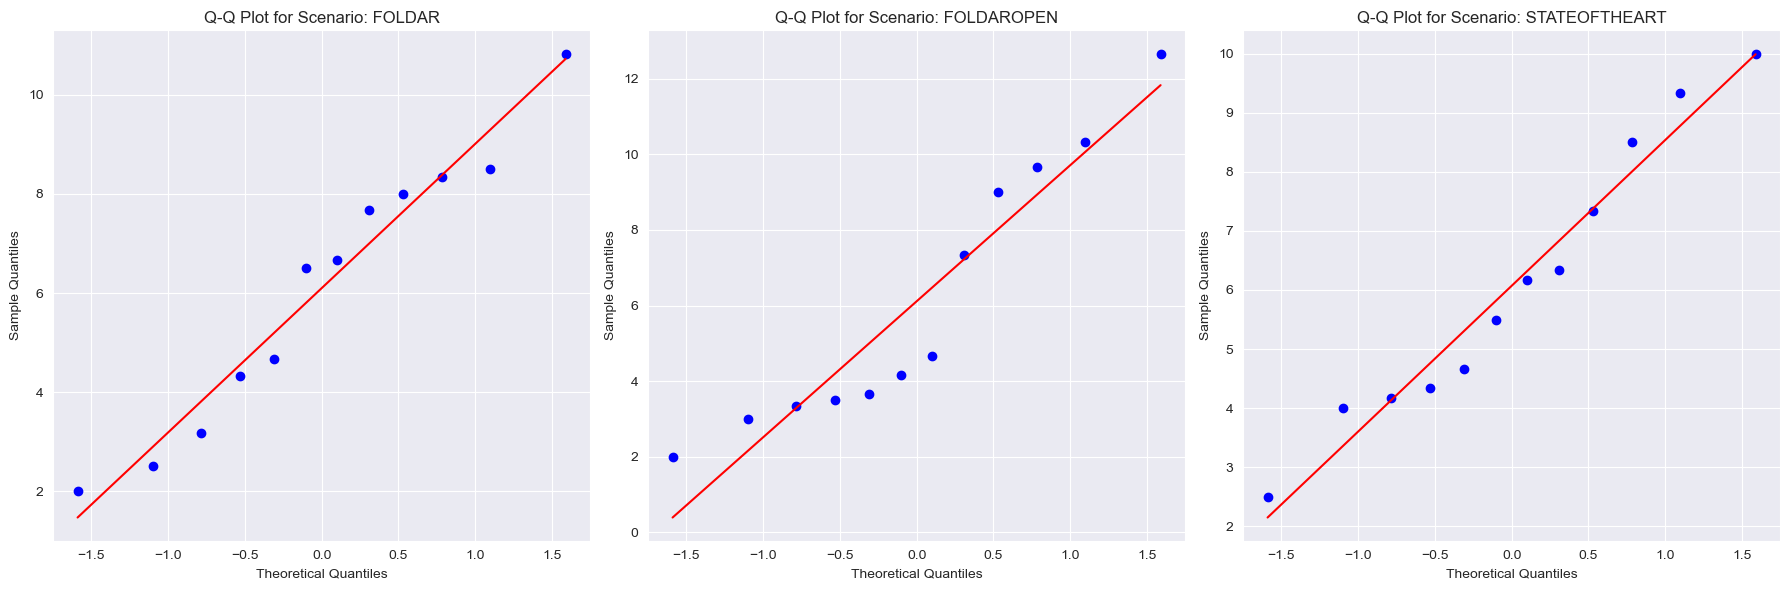

In [3]:
print("Shapiro-Wilk Normality Test Results per ScenarioCase:")
for scenario in DataCombinedAvgAggregated['ScenarioCase'].unique():
    data_scenario = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    stat, p_value = shapiro(data_scenario)
    print(f"Scenario: {scenario:<15} | Shapiro-Wilk Statistic: {stat:.12f} | p-value: {p_value:.12f}")

# Get unique scenarios
scenarios = DataCombinedAvgAggregated['ScenarioCase'].unique()
n_scenarios = len(scenarios)

# Create a subplot grid. For example, one row with n_scenarios columns:
fig, axs = plt.subplots(1, n_scenarios, figsize=(6 * n_scenarios, 6))

# In case there's only one scenario, wrap the ax in a list
if n_scenarios == 1:
    axs = [axs]

# Loop over each scenario and respective subplot axis
for ax, scenario in zip(axs, scenarios):
    data_to_plot = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    probplot(data_to_plot, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for Scenario: {scenario}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()



# Mauchlys Test

In [4]:
sphericity_results = pg.sphericity(DataCombinedAvgAggregated, dv=tested_variable, within='ScenarioCase', subject=observed_group, method='mauchly',alpha=0.05)

header = f"{'Spher':<10} {'W':<15} {'Chi2':<15} {'Dof':<10} {'P-Value':<15}"
print("\nMauchly's Test for Sphericity Results:")
print(header)
print("-" * len(header))

row = f"{str(sphericity_results.spher):<10} " \
      f"{sphericity_results.W:<15.6f} " \
      f"{sphericity_results.chi2:<15.6f} " \
      f"{sphericity_results.dof:<10} " \
      f"{sphericity_results.pval:<15.6f}"
print(row)


Mauchly's Test for Sphericity Results:
Spher      W               Chi2            Dof        P-Value        
---------------------------------------------------------------------
True       0.649454        4.316238        2          0.115542       


# Repeated Anova


Repeated Measures ANOVA Results:

+--------------+------------+------+------------+--------------+------------+---------------+------------+
| Source       |         SS |   DF |         MS |            F |      p-unc |           ng2 |        eps |
|--------------+------------+------+------------+--------------+------------+---------------+------------|
| ScenarioCase |  0.0108025 |    2 | 0.00540123 |   0.00217705 |   0.997826 |   3.86997e-05 |   0.740441 |
| Error        | 54.5818    |   22 | 2.48099    | nan          | nan        | nan           | nan        |
+--------------+------------+------+------------+--------------+------------+---------------+------------+


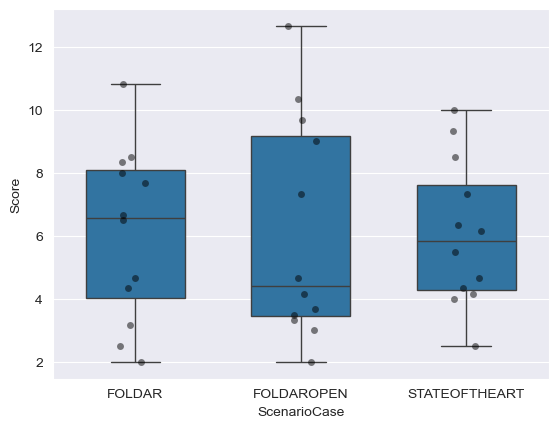

In [5]:
rm_anova = pg.rm_anova(data=DataCombinedAvgAggregated,
                       dv=tested_variable,
                       subject=observed_group,
                       within=['ScenarioCase'],
                       detailed=True)

# Print results
print("\nRepeated Measures ANOVA Results:\n")
print(tabulate(rm_anova, headers='keys', tablefmt='psql', showindex=False))

sns.boxplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, width=0.6, showfliers=False)
sns.stripplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, color='black', alpha=0.5)
plt.show()